# Startup Success Analysis

As somebody who is very interested in someday starting a company of my own, I wanted to analyze startups to see what factors affect their chances of success. This analysis starts by disecting
the many attributes of startups in a visual interactive way (answering the questions below), then utilizes a XGbooster classifier and RandomizedSearchCV hyperparameter tuning to try and predict whether a startup will be aqcuired or close, and what the resulting model deems most important to the success/failure of startups. 

The data contains information about startup funding, milestones, relationships, age, location, and more. In the future I hope to build an even larger dataset so I can build a more sophisticated model.

In this analysis, I answered the following questions:

1. **What industries and locations recieve the most funding?**
      - I found that Software related industries and California overwhelmingly recieve the most funding.
2. **Does funding and VC/angel investing correlate with startup success?**
      - I found that VC/angel investing did not correlate with startup success
3. **Does a startups number of key relationships contribute to startup success?**
      - I found that the number of relationships is correlated with startup success
4. **Does a startups number of key milestones contribute to startup success?**
      - I found that the number of key milestones correlates with startup success
5. **Does a startups number of people contribute to startup success?**
      - I found that the number of people in a startup is correlated with startup success
6. **What factors most influence a startup’s likelihood of acquisition/closure?**
      - I found that relationships, total funding, and milestones had the strongest affect on whether a company succeeds/fails

## Challenge Goals

I am using plotly for my visualizations and scipy as part of my RandomizedSearchCV code which we did not go over in class (**New Library**). Additionally I am using XGBooster as my machine learning algorithm which is not featured in SciKit learn, and with that, I am also utilizing an Imputer to fill in missing values and RandomizedSearchCV to perform hyperparameter tuning on my XGBooster. Throughout this whole project, I experimented with numerous paramaters to see what gets me the best model. I experimented with endless learning rates, weights, number of estimators, depths, subsamples, cosamples, classifier objectives, eval metrics, early stopping rounds, number of iterations, scoring metrics, cross valuations, etc. (**Advanced Machine Learning**). 

In [183]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install plotly
!pip install xgboost
!pip install joblib

In [304]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.impute import KNNImputer
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
import joblib

## Collaboration and Conduct

Students are expected to follow Washington state law on the [Student Conduct Code for the University of Washington](https://www.washington.edu/admin/rules/policies/WAC/478-121TOC.html). In this course, students must:

- Indicate on your submission any assistance received, including materials distributed in this course.
- Not receive, generate, or otherwise acquire any substantial portion or walkthrough to an assessment.
- Not aid, assist, attempt, or tolerate prohibited academic conduct in others.

Update the following code cell to include your name and list your sources. If you used any kind of computer technology to help prepare your assessment submission, include the queries and/or prompts. Submitted work that is not consistent with sources may be subject to the student conduct process.

In [307]:
your_name = "Dylan Berger"
sources = [
    "how to explicitly encode categorical to integer data python - answered with google AI, led me to pandas.replace",
    "interactive pie chart python - led me to: https://www.geeksforgeeks.org/pie-plot-using-plotly-in-python/",
    "bar plot python - https://www.geeksforgeeks.org/bar-plot-in-matplotlib/",
    "imputation techniques led me to KNN imputation which led me to https://www.geeksforgeeks.org/handling-missing-data-with-knn-imputer/",
    "https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html",
    "correlation matrix python - Google AI led me to data.corr",
    "how to save a machine learning model - https://www.geeksforgeeks.org/saving-a-machine-learning-model/",
    "randomizedsearchcv vs gridsearchcv - https://www.geeksforgeeks.org/comparing-randomized-search-and-grid-search-for-hyperparameter-estimation-in-scikit-learn/",
    "randomizedsearchcv documentation - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html",
    "I searched plotly on YouTube - https://www.youtube.com/watch?v=GGL6U0k8WYA",
    "These next plotly sources I used to help build my class",
    "https://plotly.com/python/bar-charts/",
    "https://plotly.com/python/histograms/",
    "https://plotly.com/python/box-plots/",
    "https://plotly.com/python/line-and-scatter/",
    "https://plotly.com/python/pie-charts/",
    "return current figure matplot - https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.gcf.html",
    "train/test split scikit documentation - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html",
    "XGBoost eval metrics - https://xgboost.readthedocs.io/en/stable/parameter.html",
    "XGBoost python: https://www.youtube.com/watch?v=GrJP9FLV3FE",
    "XGBoost documentation - https://xgboost.readthedocs.io/en/stable/",
    "scale_pos_weight XGBoost - https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets",
    "randomizedsearchcv parameters https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html",
    "https://www.kdnuggets.com/hyperparameter-tuning-gridsearchcv-and-randomizedsearchcv-explained",
    "classification report sklearn - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html",
    "XGboost feature importances - https://medium.com/@emilykmarsh/xgboost-feature-importance-233ee27c33a4",
    "confusion matrix python - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html",
    "sort values in column pandas - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html",
    "scipy documentation - https://projects.scipy.org/docs.html",
    "my mapping and search assessments helped me write doctests/docstrings",
    "https://courses.cs.washington.edu/courses/cse163/25wi/2025/01/31/objects/ for writing classes"
]

assert your_name != "", "your_name cannot be empty"
assert ... not in sources, "sources should not include the placeholder ellipsis"
assert len(sources) >= 6, "must include at least 6 sources, inclusive of lectures and sections"

## Data Setting and Methods

The dataset is very good for analyzing startups. There are categories for the location of the company, its age during milestones and fundings, the number of relationships, people in the startup, number of VC's, angel investors, its status, the type of company, and of course funding as a whole. A lot for us to analyze which will result in a thorough project. There are a lot of categories such as zip code, city, name, and repeats of other categories that are irrelevant to this projects analysis so that is something to be dealt with. One other thing is that the dataset may not be diverse/big enough for a machine learning model to thouroughly analyze, as it has only 923 entries and is imbalanced, favoring startups that were acquired. The good thing however, is that all the missing values are easy to deal with.

I first start by loading the dataset as a csv, then I immediately shuffled it as it is good practice before you do some machine learning. I then took a look at the shape of the dataset and 
took a look at all the null values. I discovered right away that there are several useless columns. I performed some encoding on the 'status' column which is 
the category we are trying to predict (it reveals whether the company got acquired or failed). I filled two of the columns with values determined by a KNN imputer, dropped columns that were either irrelevant, redundant, or would be incomprehensible for any machine learning algorithm.  

To answer the research questions, I plan on utilizing interative visualizations and machine learning. For the first four research questions, I will use a combination of bar charts, histograms, pie charts and box plots to visualize/analyze. For the last question I will utilize a machine learning algorithm to see what the model prioritizes and extrapolate based on that!

In [310]:
#read dataset
data = pd.read_csv('startup data.csv', header = 0)

#shuffle dataset (good measure pre-machine learning)
data = shuffle(data, random_state=42)

#encode status category
status_map = {'acquired': 1, 'closed': 0}

# Replace the values
pd.set_option('future.no_silent_downcasting', True)
data['status'] = data['status'].replace(status_map)

In [312]:
labels = ['Unnamed: 6', 'Unnamed: 0', 'state_code.1', 'first_funding_at', 'last_funding_at','state_code', 'latitude', 'longitude', 'zip_code', 'id', 'city', 'name', 'labels', 'founded_at', 
          'closed_at', 'is_top500', 'object_id','category_code',]

#creates an updated dataset with just the more useful columns
updated_data = data.drop(labels, axis=1, inplace=False)

In [314]:
def fill_nan_values(data, columns):
    """
    The function replaces NaN values in the specified columns with ones similar to its neighbours 

    Takes in the dataframe 
    
    """
    imputer = KNNImputer(n_neighbors=10)  

    data_imputed = pd.DataFrame(imputer.fit_transform(data[columns]), columns=columns)
    
    data[columns] = data_imputed

before = updated_data.isnull().sum().sum()
fill_nan_values(updated_data, ['age_first_milestone_year', 'age_last_milestone_year'])
after = updated_data.isnull().sum().sum()

assert before != after, "Imputation didn't fill anything!"
assert after == 0, "Imputation did not remove all the NaNs!"

# Results

Before I dove into the research questions, I created a class to make plotting even easier. I created functions for bar charts, box plots, scatter plots (though not used), histograms, pie charts, and correlation matrices. 

In [317]:
class Plotting:
    """
    A class for generating common data visualizations using Plotly and Seaborn.

    Attributes:
        data (pd.DataFrame): Dataset used for creating visualizations.
    """

    def __init__(self, data):
        """
        Initialize the Plotting class with a dataset.

        Args:
            data (pd.DataFrame): The data to visualize.
        """
        self.data = data

    def bar_chart(self, x, y, title="Bar Chart", color=None, hover_data=None):
        """
        Creates a bar chart with the selected columns.

        Args:
            x (str): Column name for the x-axis.
            y (str): Column name for the y-axis.
            title (str, optional): Chart title.
            color (str, optional): Column to color the bars.
            hover_data (list, optional): Columns to display on hover.
            
        Returns:
            Returns the plot
            
        """
        self.data = self.data.sort_values(by=y, ascending=False)
        fig = px.bar(self.data, x=x, y=y, title=title, hover_data=hover_data)
        fig.update_layout(hovermode="x", dragmode="zoom", width=800, height=600)

        return fig

    def box_plot(self, x, y, title="Box Plot", color=None, hover_data=None):
        """
        Creates a box plot with a categorical column (x) and a numerical column (y).

        Args:
            x (str): Column name for the x-axis.
            y (str): Column name for the y-axis.
            title (str, optional): Chart title.
            color (str, optional): Column to color the boxes.
            hover_data (list, optional): Columns to display on hover.

         Returns:
            Returns the plot
            
        """
        fig = px.box(self.data, x=x, y=y, color=color, title=title, hover_data=hover_data)
        fig.update_layout(hovermode="x", dragmode="pan", width=800, height=600)

        return fig
        
    def scatter_plot(self, x, y, title="Scatter Plot", color=None, size=None, hover_data=None):
        """
        Creates a scatter plot with the selected data columns.

        Args:
            x (str): Column name for the x-axis.
            y (str): Column name for the y-axis.
            title (str, optional): Chart title.
            color (str, optional): Column to color the points.
            size (str, optional): Column to determine point sizes.
            hover_data (list, optional): Columns to display on hover.'

         Returns:
            Returns the plot
            
        """
        fig = px.scatter(self.data, x=x, y=y, color=color, size=size, title=title, hover_data=hover_data)
        fig.update_layout(hovermode="closest", dragmode="pan", width=800, height=600)

        return fig
        
    def histogram(self, x, title="Histogram", color=None, nbins=20, hover_data=None):
        """
        Creates a histogram with the inputted data column.

        Args:
            x (str): Column name to plot.
            title (str, optional): Chart title.
            color (str, optional): Column to color the bars.
            nbins (int, optional): Number of histogram bins.
            hover_data (list, optional): Columns to display on hover.

         Returns:
            Returns the plot
        
        """
        fig = px.histogram(self.data, x=x, color=color, title=title, nbins=nbins, hover_data=hover_data)
        fig.update_layout(hovermode="x", dragmode="zoom", width=800, height=600)
        fig.show()
        
        #return fig
        
    def pie_chart(self, names, values, title="Pie Chart"):
        """
        Creates a pie chart with the inputted names, and values.

        Args:
            names (str): Column for slice labels.
            values (str): Column for slice values.
            title (str, optional): Chart title.

        Returns:
            Returns the plot
        """
        fig = px.pie(self.data, names=names, values=values, title=title)
        fig.update_layout(hovermode="x", width=800, height=600)

        return fig
        
    def correlation_matrix(self, columns=None):
        """
        Displays a correlation matrix heatmap with the selected columns.

        Args:
            columns (list, optional): Columns to include. If None, all columns are used.

        Returns:
            Returns current plot
        """
        data = self.data[columns] if columns else self.data
        corr = data.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f')
        plt.title("Correlation Matrix")

        return plt.gcf()

## 1. What industries and locations recieve the most funding?

Before I searched for the answer, I first wanted to understand the distribution of our two parameters: types of locations (states) and industries. I did this to ensure I understood more context behind the categories and how that might inform the answer. What I found from the histograms was that software related companies and companies based in California were an overwhelming majority. From this it is reasonable to predict that software related companies and companies based in California will get the most funding, but we still needed to be sure. 

To get the answer I created bar charts with funding on the y-axis and the paramater on the x-axis. I found that California had overwhelmingly more funding than the other states, though Washington put up a very respectable fight. I also found that software-related startups (mobile, web, software) recieved the most funding. Now let's analyze the results. 

The fact that California gets the most startup funding appears biased as most of the startups in the dataset are from California, but there is more nuance to it. For starters, California is a giant tech hub especially with Silicon Valley, being the home of some of the biggest companies in the world (Google, Apple, Meta), and has some of the best Universities in the world (Stanford, Caltech, etc), breeding innovation at every corner. All of these factors make California ideal for Venture Capital and other Investors, which in turn attracts startups, promotes innovation, and then coming back full circle by attracting investors. What this means is that regardless of a fully diverse dataset, we would expect most startups to be based in California. Washington is up there for very similar reasons with Microsoft, Amazon, the University of Washington, etc. The next highest ones also make sense when you consider the factors mentioned before (MA, NY, TX).

Now mobile-related companies having the most funding by a fair margin may seem a little odd, but it has a lot of sense to it. Mobile applications are some of the easiest products to build, all you need is a laptop to build something potentially huge. One would expect most startups to be software-related regardless, and these startups would be very attracted to SiliconValley and California in general (again coming full circle).

In [320]:
# plot = Plotting(data)
# plot.histogram('category_code', "Startup Category Distribution")

In [322]:
%%html
<iframe width="800" height="600" src="https://students.washington.edu/bdylant/one.html" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [324]:
# plot.histogram('state_code', "Startup Location Distribution")

In [326]:
%%html
<iframe width="800" height="600" src="https://students.washington.edu/bdylant/two.html" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [328]:
# simplified = data.groupby("category_code")["funding_total_usd"].sum().reset_index() #This was the only way my bars would properly stack
# plotting = Plotting(simplified)
# plotting.bar_chart('category_code', 'funding_total_usd')

In [330]:
%%html
<iframe width="800" height="600" src="https://students.washington.edu/bdylant/three.html" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [332]:
# simplified = data.groupby("state_code")["funding_total_usd"].sum().reset_index()
# plotting = Plotting(simplified)
# plotting.bar_chart('state_code', 'funding_total_usd')

In [334]:
%%html
<iframe width="800" height="600" src="https://students.washington.edu/bdylant/four.html" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## 2. Does funding and VC/angel investing correlate with startup success?

The data suggests that there is a small correlation between startup success and funding and little to no correlation between venture capital/angel investment. The first statement is clear with the first two box plots.
The first box plot shows that acquired companies (status = 1) have a wider interquartile range and whiskers extending up to 6 rounds compared to around 3 for closed companies. Additionally, acquired companies have outliers reaching 10 funding rounds, whereas closed companies rarely exceed 6. This suggests that companies with more funding rounds are more likely to be acquired, though some still close despite multiple rounds of funding. The second one, further answers the question by clearly showing that the successful startups on average had over double the amount of funding compared to their failed counterparts. 

This makes sense because the more funding a company has, the more freedom they have. Companies can hire a more skilled and larger workforce, they can put more money into product development and marketing, and they can operate longer before becoming profitable, giving them more time to perfect their market. More funding also implies that they may have more connections/relationships, people that can advise and promote. 

Now to the second part of the question. The pie charts tell us that half of successful startups even had a VC/Angel Investor, and around 60% of failed startups had a VC/Angel or both. This makes sense because the majority of investment ventures whether it be VC/Angel or otherwise, are failures. 1 out of 50 investments might be successful, but the one that succeeds makes up for all the failures, that is their business model. Thus outside investment is not a strong indication of startup success. 

This is not to say that VC/Angel Investing is mad however, there are many advantages such as funding (which we've identified as a correlator!), advising, relationships/connections, etc (which are also correlators). It's just that this alone is not enough to determine anything. 

In [337]:
# plot.box_plot('status', 'funding_rounds', "Company Status and number of funding rounds (0 = closed, 1 = acquired)")

In [339]:
%%html
<iframe width="800" height="600" src="https://students.washington.edu/bdylant/five.html" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [341]:
# plot.box_plot('status', 'funding_total_usd', "Company Status and total amount of funding (0 = closed, 1 = acquired)")

In [343]:
%%html
<iframe width="800" height="600" src="https://students.washington.edu/bdylant/six.html" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [345]:
#counts the number successful and failed startups
successful = data['status'] == 1
failed = data['status'] == 0

total_success = successful.sum()
total_failed = failed.sum()

#gets percentages
both_success = ((data['has_VC'] & data['has_angel']) & successful).sum() / total_success * 100
vc_only_success = ((data['has_VC'] & ~data['has_angel']) & successful).sum() / total_success * 100
angel_only_success = ((~data['has_VC'] & data['has_angel']) & successful).sum() / total_success * 100
neither_success = ((~data['has_VC'] & ~data['has_angel']) & successful).sum() / total_success * 100

both_failed = ((data['has_VC'] & data['has_angel']) & failed).sum() / total_failed * 100
vc_only_failed = ((data['has_VC'] & ~data['has_angel']) & failed).sum() / total_failed * 100
angel_only_failed = ((~data['has_VC'] & data['has_angel']) & failed).sum() / total_failed * 100
neither_failed = ((~data['has_VC'] & ~data['has_angel']) & failed).sum() / total_failed * 100

assert (both_success + vc_only_success + angel_only_success + neither_success) == 100, "The percentages do not add up to 100!"
assert (both_failed + vc_only_failed + angel_only_failed + neither_failed) == 100, "The percentages do not add up to 100!"

#lists for the pie charts below
succeed_pie_list = [both_success, vc_only_success, angel_only_success, neither_success]
fail_pie_list = [both_failed, vc_only_failed, angel_only_failed, neither_failed]

In [347]:
# plot.pie_chart(values = succeed_pie_list, names=["Both", "Only VC", "Only Angel", "Neither"], title="Successful Startups")

In [349]:
%%html
<iframe width="800" height="600" src="https://students.washington.edu/bdylant/seven.html" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [351]:
# plot.pie_chart(values = fail_pie_list, names=["Both", "Only VC", "Only Angel", "Neither"], title = "Failed Startups")

In [353]:
%%html
<iframe width="800" height="600" src="https://students.washington.edu/bdylant/eight.html" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## 3. Does a startups number of key relationships contribute to startup success?

For clarity's sake, 'relationships' refers to the amount of connections that a business has. This is primarily key investors, partnering businesses, suppliers, etc. It is clear that the number of relationships has a positive correlation with startup success. Every business mind will tell you that it is not merely what you know, but who you know. Connections are everything. This box plot displays this with successful startups having on average, quite a few more connections than startups that failed. 

In [356]:
# plot.box_plot('status', 'relationships', "Company Status and amount of relationships (0 = closed, 1 = acquired)")

In [358]:
%%html
<iframe width="800" height="600" src="https://students.washington.edu/bdylant/nine.html" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## 4. Does a startups number of key milestones and people contribute to startup success?

There is a positive correlation between key milestones and startup success. The box plot shows that successful startups have a higher median number of milestones with more variability beyond that. This makes sense as milestones is simply the company achieving its goals. The more goals achieved, the more sucessful the startup becomes. Additionally, the more people the startup has, the more likely they are to succeed as they have more brainpower/manpower working toward the same goal

In [361]:
# plot.box_plot('status', 'milestones', "Company Status and amount of milestones they achieved (0 = closed, 1 = acquired)")

In [363]:
%%html
<iframe width="800" height="600" src="https://students.washington.edu/bdylant/ten.html" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## 5. Does a startups number of key milestones and people contribute to startup success?

There is a positive correlation between number of people and startup success. The box plot shows that successful startups have on average more participants. This makes sense as the more manpower/brainpower a company has working toward the same goal, the more likely they are to achieve it, and succeed beyond

In [366]:
# plot.box_plot('status', 'avg_participants', "Company Status and amount of people involved in startup (0 = closed, 1 = acquired)")

In [368]:
%%html
<iframe width="800" height="600" src="https://students.washington.edu/bdylant/eleven.html" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## 6. What factors most influence a startup’s likelihood of acquisition/closure?

This question is designed to be answered with machine learning. I have a class below that prepares the train/testing data, implements the XGBoost classifier, hyperparameter tunes it with RandomizedSearchCV, and then creates a graph of feature importances and a confusion matrix. However, it did not start like this. 

I began by asking myself what I wanted the model to prioritize. Should it focus on precision, minimizing false positives? Recall, minimizing false negatives? Or a balance of the two (F1 score)? A precision-focused model ensures that when it predicts a certain outcome (e.g., a startup failing), it's likely to be correct—but it may miss other failing startups. A recall-focused model, on the other hand, will catch most failing startups but might incorrectly classify too many as failures. I chose to optimize for a balance (F1 score).

After building the initial XGBoost model, I realized the sheer number of hyperparameters made manual tuning impractical. So, I employed RandomizedSearchCV, which explores a set number of combinations (n_iter) of depths, estimators, and learning rates, selecting the best model based on a scoring metric. I found that roc_auc worked best as a general-purpose metric. This process evolved into the class you see below, where all I need to specify is the number of RandomizedSearchCV iterations, the cross-validation folds, and the number of rounds before stopping.

I experimented endlessly—testing different hyperparameters, feature sets, train/test splits, class weights, and even removing outliers (which worsened performance, so I left them in).

In the end, the best model achieved an average F1 score of 0.82—not bad at all.

The most influential feature, by far, was relationships. I didn’t expect it to be so dominant, but it makes sense: strong business connections are critical for any startup. No company succeeds in isolation—the more connections, the more resources available. Given this, it's unsurprising that the second most important feature was avg_participants (number of people involved). More people mean more brainpower and manpower. After that came milestones and total funding, both fairly self-explanatory—one reflects a company’s ability to hit major goals, and the other represents its financial resources. The remaining features were loosely related but not as impactful.

Ultimately, the model identified a key truth: despite high funding, early successes, and strong investors, what really matters is the people. Countless startups look great on paper but still fail. While luck, economic conditions, and regulations play a role, a company’s success hinges on the people behind it. That’s what the model prioritizes—and it’s a perspective that makes a lot of sense.

In [62]:
class ModelTrainer:
    """
    A class for training and evaluating machine learning models, specifically using XGBoost for binary classification.
    """

    def __init__(self, df: pd.DataFrame):
        """
        Initializes the ModelTrainer with a pandas DataFrame.

        Args:
            df (pd.DataFrame): The dataset containing features and the target column.
        """
        self.df = df
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None
    
    def prepare_data(self, drop_columns: list[str], target_column: str, test_size: float = 0.3):
        """
        Prepares the data by splitting it into training and testing sets.

        Args:
            drop_columns (list[str]): List of column names to drop from the feature set.
            target_column (str): Name of the target column.
            test_size (float, optional): Fraction of data to use for testing. Defaults to 0.3.

        Returns:
            tuple: A tuple containing the training features and training labels.
        """
        X = self.df.drop(columns=drop_columns)
        y = self.df[target_column].astype(int)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        return self.X_train, self.y_train

    def xgboost_classifier(self, n_iter: int = 30, cross_val: int = 3, early_stopping_rounds: int = 10):
        """
        Trains an XGBoost classifier using randomized hyperparameter search and evaluates its performance.

        Args:
            n_iter (int, optional): Number of parameter settings sampled in RandomizedSearchCV. Defaults to 30.
            cross_val (int, optional): Number of cross-validation folds. Defaults to 3.
            early_stopping_rounds (int, optional): Number of rounds with no improvement to stop training early. Defaults to 10.
        """
        minority_class = (self.y_train == 0).sum()
        majority_class = (self.y_train == 1).sum()
        
        scale_pos_weight = minority_class / majority_class 
        
        param_distributions = {
            'n_estimators': randint(10, 500),
            'max_depth': randint(3, 20),
            'learning_rate': uniform(0.01, 0.3),
            'subsample': uniform(0.5, 0.5),
            'colsample_bytree': uniform(0.5, 0.5),
            'scale_pos_weight': [scale_pos_weight]
        }

        xgb = XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            random_state=42,
            early_stopping_rounds=early_stopping_rounds
        )

        random_search = RandomizedSearchCV(
            estimator=xgb,
            param_distributions=param_distributions,
            n_iter=n_iter,
            scoring='roc_auc',
            cv=cross_val,
            verbose=0,
            n_jobs=-1,
            random_state=42
        )

        random_search.fit(
            self.X_train, self.y_train,
            eval_set=[(self.X_test, self.y_test)],
            verbose=False
        )

        print("Best Parameters Found:", random_search.best_params_)
        
        self.model = random_search.best_estimator_

        y_pred = self.model.predict(self.X_test)

        accuracy = accuracy_score(self.y_test, y_pred)
        print(f"XGBoost Accuracy after RandomizedSearch: {accuracy * 100:.2f}%")

        class_report = classification_report(self.y_test, y_pred, zero_division=0)
        print("Classification Report:")
        print(class_report)
        
    def feature_importances(self):
        """
        Displays a bar plot of the feature importances from the trained XGBoost model.
        """
        feature_importances = self.model.feature_importances_
        features = self.X_train.columns
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importances, y=features, orient='h')
        plt.xlabel("Feature Importance")
        plt.ylabel("Feature")
        plt.title("Feature Importances")
        plt.show()
    
    def confusion_matrix(self):
        """
        Displays a confusion matrix heatmap of the model's predictions on the test set.
        """
        y_pred = self.model.predict(self.X_test)
        cm = confusion_matrix(self.y_test, y_pred)
        
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.model.classes_, yticklabels=self.model.classes_)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()



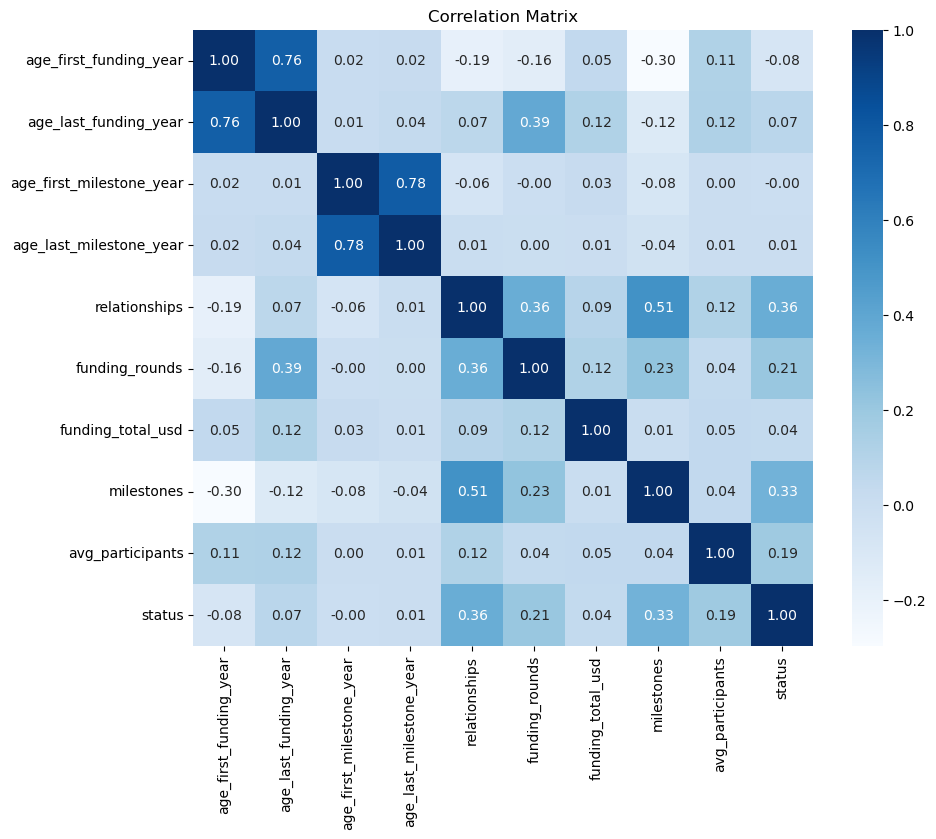

In [37]:
numerical_cols = ['age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 
                  'funding_total_usd', 'milestones', 'avg_participants', 'status']

plot.correlation_matrix(numerical_cols)

Best Parameters Found: {'colsample_bytree': 0.8854921462660678, 'learning_rate': 0.22257160138078882, 'max_depth': 3, 'n_estimators': 31, 'scale_pos_weight': 0.5463510848126233, 'subsample': 0.8104577588837385}
XGBoost Accuracy after RandomizedSearch: 84.17%
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77        49
           1       0.87      0.89      0.88        90

    accuracy                           0.84       139
   macro avg       0.83      0.82      0.82       139
weighted avg       0.84      0.84      0.84       139



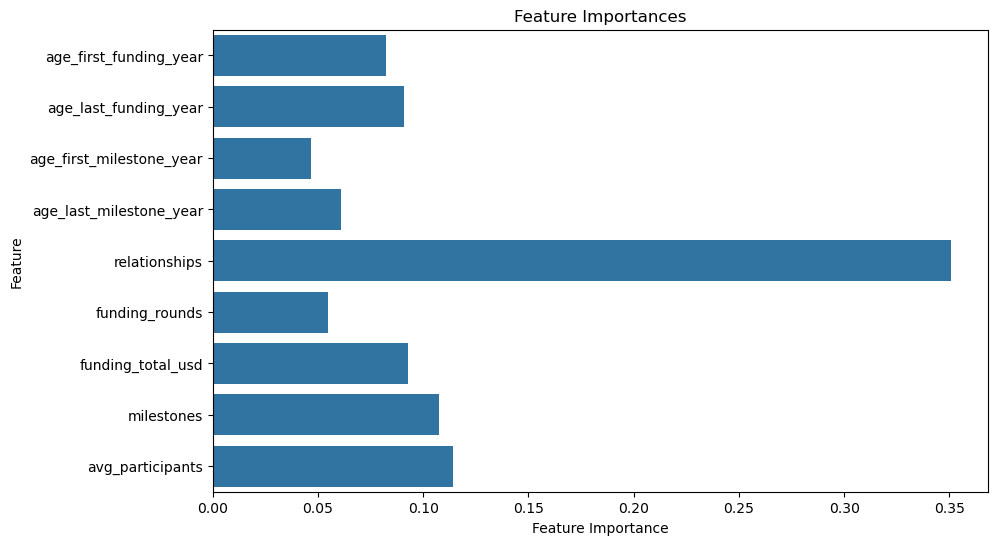

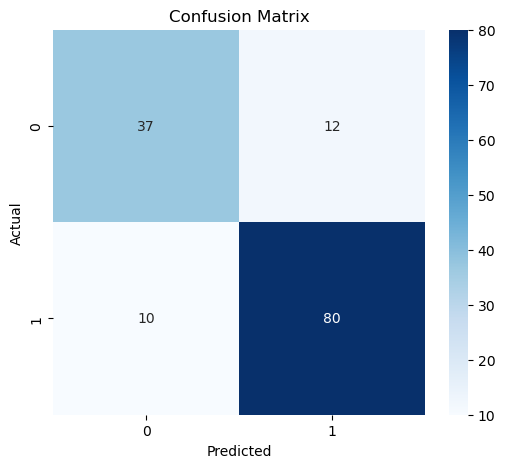

In [39]:
drop_columns = ['status', 'is_NY', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'has_roundA','has_roundB','has_roundC','has_roundD', 'has_VC', 'is_biotech', 'is_consulting', 
                'has_angel', 'is_enterprise', 'is_TX', 'is_software', 'is_web', 'is_othercategory', 'is_MA', 'is_CA', 'is_otherstate', 
               'is_mobile']

target_column = 'status'

training = ModelTrainer(updated_data)

training.prepare_data(drop_columns, target_column, test_size=0.15)

model2 = training.xgboost_classifier(n_iter=1000, cross_val=5, early_stopping_rounds=10)

training.feature_importances()

training.confusion_matrix()

## Implications and Limitations

This analysis offers a strong perspective on what contributes to a company's success or failure, but it is important to recognize its limitations. The model prioritized people-oriented categories, yet many other crucial factors—such as debt, founder and employee credentials, investor quality, product-market fit, economic conditions, revenue, profitability, burn rate, and marketing attention—were not fully considered. While including these factors would significantly complicate the dataset, it would also deepen the analysis. Additionally, the dataset itself was relatively small, containing only 923 companies; the startup world is humongous, a much larger dataset could result in a more diverse model as the current dataset may be omitting certain industries/categories. There is a class/industry imbalance as seen earlier in the analysis, a bigger dataset could shed light on underrepresented startups! Furthermore, the startup world is inherently chaotic, filled with outliers and diverse situations, making it difficult for any machine learning model to fully predict or understand success and failure. It is somewhat akin to predicting the stock market—while informed decisions can be made, there will always be an element of uncertainty due to the countless variables at play. 

This analysis is particularly valuable for casual learners and analysts looking for insights into startup success, emphasizing that beyond the data and numbers, people remain at the heart of it all. However, it should not be used as a definitive tool for predicting success, as doing so could lead to misleading conclusions. Instead, it serves as a way to explore patterns and gain a deeper understanding of the factors at play. While it does not paint a complete picture, it uncovers a hidden layer that contibutes to the whole picture as much as anything else!
